## Uploading Kaggle Json file

In [ ]:
#we will upload kaggle.json file which will help us in loading kaggle dataset here in colab.
from google.colab import files
files.upload()

# making kaggle directory and copying kaggle.json file inside kaggle directory.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


## Downloading Pretrained Weights

In [ ]:
!kaggle datasets download -d absolutegaming/pre-trained-weights #Load Pretrained Weights

 98% 216M/220M [00:03<00:00, 49.3MB/s]
100% 220M/220M [00:03<00:00, 66.4MB/s]


In [ ]:
!unzip '/content/pre-trained-weights.zip'

Archive:  /content/pre-trained-weights.zip
  inflating: yolov3.weights          


## Downloading main data

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/19989/1160143/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1598706338&Signature=eKQ5C%2FDTJiP6YJ1OaKXxMMcXpw7SpppFElwl9rPX4%2B9DEDsQl0yCsJlbADBuVfBAVDy1ah6JqmcKas8i%2FKPNC9spRd8QvFySBlwd6UcWZUXz%2BJQLf9BM3EzlOHjweVOnV2hYb7vBglH0LUqUC44Upd2aAtJhvJ7NDamCHeva7iTyMh%2F24au78nytB2oVfshyag3QYNg8bxW7nT7Dy3A6DU9jFFGrlTuKHD%2FS0wHsCqPutglvehA%2FEicH0Dr%2Bd7yXEZaAfGm%2BGzk%2FC5%2FxFRNDfCo%2BzSCFLQcYpZg8E5ceaFgDDvtNbWGvB1yP3MTneCAIRZNrPflMAjheZtWKaPK43Q%3D%3D&response-content-disposition=attachment%3B+filename%3Dglobal-wheat-detection.zip" -c -O 'global-wheat-detection.zip'

--2020-08-27 05:37:36--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/19989/1160143/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1598706338&Signature=eKQ5C%2FDTJiP6YJ1OaKXxMMcXpw7SpppFElwl9rPX4%2B9DEDsQl0yCsJlbADBuVfBAVDy1ah6JqmcKas8i%2FKPNC9spRd8QvFySBlwd6UcWZUXz%2BJQLf9BM3EzlOHjweVOnV2hYb7vBglH0LUqUC44Upd2aAtJhvJ7NDamCHeva7iTyMh%2F24au78nytB2oVfshyag3QYNg8bxW7nT7Dy3A6DU9jFFGrlTuKHD%2FS0wHsCqPutglvehA%2FEicH0Dr%2Bd7yXEZaAfGm%2BGzk%2FC5%2FxFRNDfCo%2BzSCFLQcYpZg8E5ceaFgDDvtNbWGvB1yP3MTneCAIRZNrPflMAjheZtWKaPK43Q%3D%3D&response-content-disposition=attachment%3B+filename%3Dglobal-wheat-detection.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 636694264 (607M) [application/zip]
Saving to: ‘global-wheat-detectio

In [ ]:
!unzip 'global-wheat-detection.zip'

## Loading all the necesssary Modules

In [ ]:
from absl import logging
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add,Concatenate,Conv2D,Input,Lambda,LeakyReLU,MaxPool2D,UpSampling2D,ZeroPadding2D,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2
import pandas as pd
from tqdm import tqdm
import os
import tensorflow as tf
import time
from tqdm import tqdm
import datetime
import ast

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading Data into Dataframe

In [ ]:
train_df = pd.read_csv('/content/train.csv') #Load the CSV file
train_df['image_id'] = '/content/train/' + train_df['image_id'].astype(str)+'.jpg' #Add the path to the images

## Preprocessing the data

In [ ]:
train_df[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train_df.bbox.tolist()], index= train_df.index)
train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
train_df['area'] = train_df['width'] * train_df['height']
train_df['x_max'] = train_df['x_min'] + train_df['width']
train_df['y_max'] = train_df['y_min'] + train_df['height']
train_df = train_df.drop(['bbox', 'source'], axis=1)
train_df = train_df[['image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'width', 'height', 'area']]

# There are some buggy annonations in training images having huge bounding boxes. Let's remove those bboxes
train_df = train_df[train_df['area'] < 100000]

In [ ]:
train_df = train_df.drop(['width','height','area'],axis = 1) #Dropping unwanted columns
class_list = ['Wheat']*train_df.shape[0]  
train_df['category'] = class_list  #Adding category column
label_list = [1]*train_df.shape[0] 
train_df['label'] = label_list #Adding class label to each row
train_df.columns = ['img_path','min_w','min_h','max_w','max_h','category','label'] #Changing Column names

df = train_df  #Loading a copy into df
df = df[['max_h', 'max_w', 'min_h', 'min_w', 'category', 'img_path', 'label']] #Changing the order of columns
print(df.head(5))

   max_h  max_w  min_h  min_w category                      img_path  label
0  258.0  890.0  222.0  834.0    Wheat  /content/train/b6ab77fd7.jpg      1
1  606.0  356.0  548.0  226.0    Wheat  /content/train/b6ab77fd7.jpg      1
2  664.0  451.0  504.0  377.0    Wheat  /content/train/b6ab77fd7.jpg      1
3  202.0  943.0   95.0  834.0    Wheat  /content/train/b6ab77fd7.jpg      1
4  261.0  150.0  144.0   26.0    Wheat  /content/train/b6ab77fd7.jpg      1


## Test Train Split

In [ ]:
max_boxes = df.groupby(['img_path']).count()['category'].max()
print('Max number of boxes in a given image are :',max_boxes) #Calculating maximum number of boxes in an image

index = list(set([i.split('/')[-1] for i in df['img_path'].values]))
print('Total number of unique images in the dataframe :',len(index))  #Taking out all the unique images in the df

#Here for simplicity sake i am using 1000 images as train and 200 images as test.
print('Splitting into train and test data......')
train_image=index[0:2500]
test_image =index[2500:3733]
print('Number of images in train data :',len(train_image))
print('Number of images in test data  :',len(test_image))

Max number of boxes in a given image are : 116
Total number of unique images in the dataframe : 3373
Splitting into train and test data......
Number of images in train data : 2500
Number of images in test data  : 873



## Initializing all the necessary variables

In [ ]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 320
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

size = 320 # size of resize image
batch_size = 8 #Batch size that we want to load when training
yolo_max_boxes = 116 # maximum yolo boxes predicted per image.
yolo_iou_threshold = 0.5 # IOU threshold score 
yolo_score_threshold = 0.4 # objectness threshold score
learning_rate = 1e-4 # learning rate
num_classes = 2 # num of category in our dataset
epochs = 30 # epochs run to fine tune our model
class_dict = {'Wheat':1} # Mapping of category and its corresponding label

# YOLOV3 architecture starts here

In [ ]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1: 
        padding = 'same' 
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding 
        padding = 'valid' 
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x) # by default alpha is 0.3
    return x

In [ ]:
# below is residual connection layer function
def DarknetResidual(x, filters):
    prev = x # storing input in prev variable 
    x = DarknetConv(x, filters // 2, 1) 
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x]) # residual connection
    return x

In [ ]:
# this is our real Darknetblock function calling above 2 fucntions 
def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2) 
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

In [ ]:
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4) # last layer detecting bounding box dimension (tx,ty,bx,by)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [ ]:
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            # upsampling of a layer
            x = UpSampling2D(2)(x)
            # concatenation of skip connection result and last output result
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
        
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

## YOLO output

In [ ]:
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:]) # this is an input shape excluded with batch size.
        x = DarknetConv(x, filters * 2, 3) # Darkconv is a fn implemented above which is internally calling
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        # x is reshaped into (None, grid_size, grid_size, anchors, (x,y,w,h,objectness score,..classes))
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

## Non Max Supression

In [ ]:
def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    # objectness : it's means whether there is any object in a predicted box
    # class_probs : it's a probability of a class given object is there i.e P(Pc|object)

    box_xy = tf.sigmoid(box_xy) 
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2 
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

def yolo_nms(outputs, anchors, masks, classes):
    # boxes, confidence scores(objectness scores), class probabilities

    b, c, t = [], [], []

    # iterating through each outputs predicted by model
    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs # this is P(Pc|objectness score) value
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class = yolo_max_boxes, # here it is 223, define above 
        max_total_size = yolo_max_boxes,
        iou_threshold = yolo_iou_threshold, # threshold for filtering the boxes
        score_threshold = yolo_score_threshold # threshold for objectness score below which we ignore that bounding box
    )

    return boxes, scores, classes, valid_detections

## Backbone Darknet Architecture

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels], name='input') # input of an image

    x_36, x_61, x = Darknet(name='yolo_darknet')(x) # backbone networks 3 outputs w.r.t to each grid size
    # till here darknet network

    # from below it's a Feature Pyramind Network with lateral connections
    # for 13*13 grid size output
    x = YoloConv(512, name='yolo_conv_0')(x) 
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)
    
    # for 26*26 grid size output
    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    # for 52*52 grid size output
    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    # for 13*13 grid size output
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    # for 26*26 grid size output
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    # for 52*52 grid size output
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)
    #  after combining boxes from various scales we have total 10,647 boxes which is too large
    # so to remove invalid boxes we use non_maximum_suppression 

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')


## Custom Loss Function

In [ ]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1) 

        # the above split function split (x1,y1,x2...cls) into (x1,y1),(x2,y2),(obj),(cls)
        # the 4,1,1 is a length at which it split

        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2 # finding center (Xcen,Ycen)
        true_wh = true_box[..., 2:4] - true_box[..., 0:2] # width and height

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32) # this code snippet giving us at which point each cell is starting and ending
            # in resize image of 416 * 416 
            # suppose there 13*13 = 169 cells , so every cell we will have starting and ending point
        true_wh = tf.math.log(true_wh / anchors) 
        # YOLO doesn’t predict the absolute coordinates of the bounding box’s center
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        
        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        # obj_loss = obj_mask * obj_loss + \
        #     (1 - obj_mask) * ignore_mask * obj_loss
        
        alpha = 0.75 # focal loss hyperparameter
        conf_focal = tf.pow(obj_mask-tf.squeeze(tf.sigmoid(pred_obj),-1),2)
        obj_loss = conf_focal*((1-alpha)*obj_mask*obj_loss + alpha*(1-obj_mask)*ignore_mask*obj_loss)  # batch * grid * grid * anchors_per_scale

        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

## Some useful functions

In [ ]:
YOLOV3_LAYER_LIST = ['yolo_darknet','yolo_conv_0','yolo_output_0','yolo_conv_1',
                     'yolo_output_1','yolo_conv_2','yolo_output_2',]

def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb') # reading weights file
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    layers = YOLOV3_LAYER_LIST

    # iterating through all layers define in above yolov3_layers_list
    for layer_name in layers:
        # for eg if there is one layer darknet then there is many sub layers inside it's network
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'): 
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()



def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape) # it will change the shape of box into new_shape given
    box_2 = tf.broadcast_to(box_2, new_shape)

    # in below code we are finding intersection box width and height through which we will find intersection area.
    # and this we are finding all boxes 
    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0) 
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0) 
    int_area = int_w * int_h  # area of intersection
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1]) # this box_1_area contains all boxes area predicted in an image
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1]) # this box2_area is our ground truth box area

    # Formula: Union(A,B) = A + B - Inter(A,B)
    return int_area / (box_1_area + box_2_area - int_area)


def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

#### Dataset Loader And Transformation

In [ ]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0

    # below iteration change the values and update it to the format which acceptable by yolov3.
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0): 
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4] #(x1,y1,x2,y2)
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2 # ((x1+x2)/2,(y1+y2)/2)

                # which is (Xcenter,Ycenter)

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32) # multiplying it by grid_size

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]]) 
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1
    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


In [ ]:
def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32 # suppose we input 416 size then grid size is 416//32 = 13

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32) # casting every anchors to float
    anchor_area = anchors[..., 0] * anchors[..., 1] # calculating the area of anchors
    box_wh = y_train[..., 2:4] - y_train[..., 0:2] # here we are peforming xmax-xmin,ymax-ymin using vectors
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1] # these are our Ground Truth Box Area
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1]) # here we tring to get IOU area 
    iou = intersection / (box_area + anchor_area - intersection) # simple operation of Intersection/Union
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32) # storing those anchor index which has highest IOU number
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2 # here we are calling the above function for 13*13 grid then, 26*26 grid then, 52*52 grid.

    return tuple(y_outs)

#### Loading Yolov3 weights into Model

In [ ]:
%%time
yolo = YoloV3(classes=80)
yolo.summary()
load_darknet_weights(yolo,"/content/yolov3.weights", False)
yolo.save_weights("/content/yolov3_checkpoint/yolov3.tf")

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, None, None, 5 11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, None, None, 2 2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

## Data Parsing Function

In [ ]:
def parse_dataset(data,class_dict,size,image,path,yolo_max_boxes,count=0):
    X = []
    Y = []
    for img in tqdm(image):
        x_train = Image.open(path+img) # reading image
        width,height = x_train.size # storing actual width and height so that we can later scale it
        x_train = x_train.resize((size,size)) # resizing 
        x_train = np.array(x_train)
        temp_data = []
        # ierating over dataset having info about objects in an image
        for _,row in data[data['img_path']==path+img].iterrows():
            xmin = row.min_w/width
            xmax = row.max_w/width
            ymin = row.min_h/height
            ymax = row.max_h/height
            cls = class_dict[row.category]
            temp_data.append([xmin,ymin,xmax,ymax,cls])
        temp_data = temp_data+[[0,0,0,0,0]]*(yolo_max_boxes-len(temp_data)) # it's like padding 
        #return(temp)
        Y.append(temp_data)
        X.append(x_train)
    return(np.array(X),np.stack(np.array(Y)))

# transforming each image and normalizing it in range [0,1]
def transform_images(x,size):
    x = tf.image.resize(x,(size,size))
    x = x/255.0
    return(x)

## Loading Train  and Validation dataset

In [ ]:
x,y= parse_dataset(
   df,class_dict,size,train_image[:],'/content/train/',116) 
# df = data
x = x.astype(np.float32)
y = y.astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x,y))

train_dataset = train_dataset.shuffle(buffer_size=64) # Randomizing the data
train_dataset = train_dataset.batch(8) # Setting Batch size
train_dataset = train_dataset.map(lambda x, y: (transform_images(x, size),
                                  transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) # Prefetching for faster performance

100%|██████████| 2500/2500 [01:39<00:00, 25.10it/s]


In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 320, 320, 3), ((None, 10, 10, 3, 6), (None, 20, 20, 3, 6), (None, 40, 40, 3, 6))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>

In [ ]:
# parsing valid dataset 
x,y= parse_dataset(df,class_dict,size,test_image[:],'/content/train/',116) 
x = x.astype(np.float32)
y = y.astype(np.float32)
val_dataset = tf.data.Dataset.from_tensor_slices((x,y))

val_dataset = val_dataset.shuffle(buffer_size=16)
val_dataset = val_dataset.batch(8)
val_dataset = val_dataset.map(
    lambda x, y: (transform_images(x, size),
    transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))

val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

100%|██████████| 873/873 [00:35<00:00, 24.49it/s]


In [ ]:
val_dataset

<PrefetchDataset shapes: ((None, 320, 320, 3), ((None, 10, 10, 3, 6), (None, 20, 20, 3, 6), (None, 40, 40, 3, 6))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>

## Model Training

In [ ]:
model = YoloV3(size, training=True, classes=num_classes)
anchors = yolo_anchors
anchor_masks = yolo_anchor_masks

## Loading Pretrained model and freezing for transfer learning

In [ ]:
%%time
model_pretrained = YoloV3(size, training=True, classes=80)
model_pretrained.load_weights("/content/yolov3_checkpoint/yolov3.tf")
model.get_layer('yolo_darknet').set_weights(
model_pretrained.get_layer('yolo_darknet').get_weights())
freeze_all(model.get_layer('yolo_darknet'))

CPU times: user 4.39 s, sys: 184 ms, total: 4.58 s
Wall time: 4.5 s


## Defining Optimizer and Loss for the YOLO model

In [ ]:
 # we are using graph mode of tensorflow so that we can use our own Gradient Tape
optimizer = tf.keras.optimizers.Adam(lr=1e-4) # Adam optimizers
loss = [YoloLoss(anchors[mask], classes=num_classes) # customized yolo loss define above in utils.
            for mask in anchor_masks]

#### Calculating Loss using Gradient Tape

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
train_log_dir = '/content/320_logs/gradient_tape/' + current_time + '/train' # train dir path
test_log_dir = '/content/320_logs/gradient_tape/' + current_time + '/test' # test dir path
train_summary_writer = tf.summary.create_file_writer(train_log_dir) # train writer
test_summary_writer = tf.summary.create_file_writer(test_log_dir) # test writer

In [ ]:
avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model = model)
manager = tf.train.CheckpointManager(ckpt, '/content/320_checkpoints/yolov3_train/tf_ckpts', max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored from {}".format(manager.latest_checkpoint))
  start = ckpt.step.numpy() 
else:
  print("Initializing from scratch.")
  start = 0

epochs = 100
for epoch in range(start, epochs+1):
    for batch, (images, labels) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            outputs = model(images, training=True)
            regularization_loss = tf.reduce_sum(model.losses)
            pred_loss = []
            for output, label, loss_fn in zip(outputs, labels, loss):
                pred_loss.append(loss_fn(label, output))
            total_loss = tf.reduce_sum(pred_loss) + regularization_loss
        # calculating grads over trainable parameters
        grads = tape.gradient(total_loss, model.trainable_variables) # calculating loss after each batch 
        optimizer.apply_gradients(
            zip(grads, model.trainable_variables)) # then appliying gradient optimization on the loss to fine tune the weights 

        # writing summary to train file(for tensorboard)

        with train_summary_writer.as_default():
          tf.summary.scalar('avg_loss', total_loss.numpy(), step=epoch)
        # to update avg loss after each batch.
        avg_loss.update_state(total_loss)
    
    # testing datasets
    for batch, (images, labels) in enumerate(val_dataset):
        outputs = model(images)
        regularization_loss = tf.reduce_sum(model.losses)
        pred_loss = []
        for output, label, loss_fn in zip(outputs, labels, loss):
            pred_loss.append(loss_fn(label, output))
        total_loss = tf.reduce_sum(pred_loss) + regularization_loss

        # writing summary to test file(for tensorboard)

        with test_summary_writer.as_default():
          tf.summary.scalar('avg_val_loss', total_loss.numpy(), step=epoch)
        avg_val_loss.update_state(total_loss)

    # print result 
    print("{}, train: {}, val: {}".format(epoch,
        avg_loss.result().numpy(),
        avg_val_loss.result().numpy()))
    
    ckpt.step.assign_add(1)
    if int(ckpt.step) % 5 == 0:
      save_path = manager.save()
      print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

    avg_loss.reset_states()
    avg_val_loss.reset_states()


## Loading Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir 320_logs

<IPython.core.display.Javascript object>

## Saving the model weights 

In [ ]:
model.save_weights('/content/Model_Save')

## Utility functions that help in visualizations

In [ ]:
# below function will help in comparing the results when we visualize it after we have pre-trained our model.

def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs # predicted outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    # iterate through each valid predictions
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32)) # 
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2) # it will create a rectangle box around object.
    return img

# below function draws grounf truth boxes
class_names = {j:i for i,j in class_dict.items()}
def draw_gt_outputs(path, data, class_names):
    img = plt.imread("/content/train/"+path)
    wh = np.flip(img.shape[0:2])
    nums,classes = [],[]
    for _,row in data[data.img_path=="/content/train/"+path].iterrows():
        xmin = row.min_w # x1
        xmax = row.max_w # x2
        ymin = row.min_h # y1
        ymax = row.max_h # y2
        nums.append([xmin,ymin,xmax,ymax])
        classes.append(row.label)
    nums = np.array(nums)
    for i in range(nums.shape[0]):
        x1y1 = tuple((np.array(nums[i][0:2])).astype(np.int32)) # 
        x2y2 = tuple((np.array(nums[i][2:4])).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2) # it will create a rectangle box around object.
    return img


## Creating new DF with bbox counts

In [ ]:
img_data = df['img_path'].value_counts()
df1 = pd.DataFrame({'image':img_data.index, 'count':img_data.values})

In [ ]:
yolo = YoloV3(classes=num_classes)
yolo.load_weights('/content/Model_Save')

In [ ]:
print('HELLO')

HELLO


# Final Pipeline

In [ ]:
def Final_pipeline(data,indx,visualize=False):
  yolo = YoloV3(classes=num_classes)
  yolo.load_weights('/content/Model_Save')
  class_names = list(class_dict.keys())
  img_raw = tf.image.decode_image(
  open('/content/train/'+data[indx], 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, size)
  img1 = img[0][:]
  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
  
  if visualize:
    plt.figure(figsize=(24,8))
    plt.subplot(1,2,1)
    plt.title("original {}".format(data[indx]))
    gt_img = draw_gt_outputs(data[indx],df,class_names)
    plt.imshow(gt_img)
    plt.subplot(1,2,2)
    plt.title("Predicted {}".format(data[indx]))
    plt.imshow(img)

## Visualising Dense images

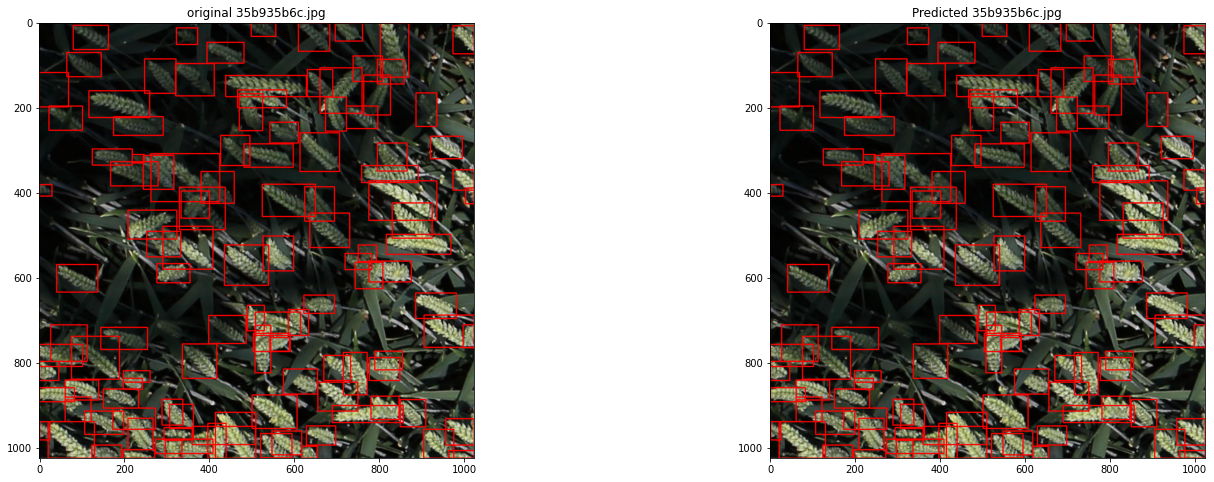

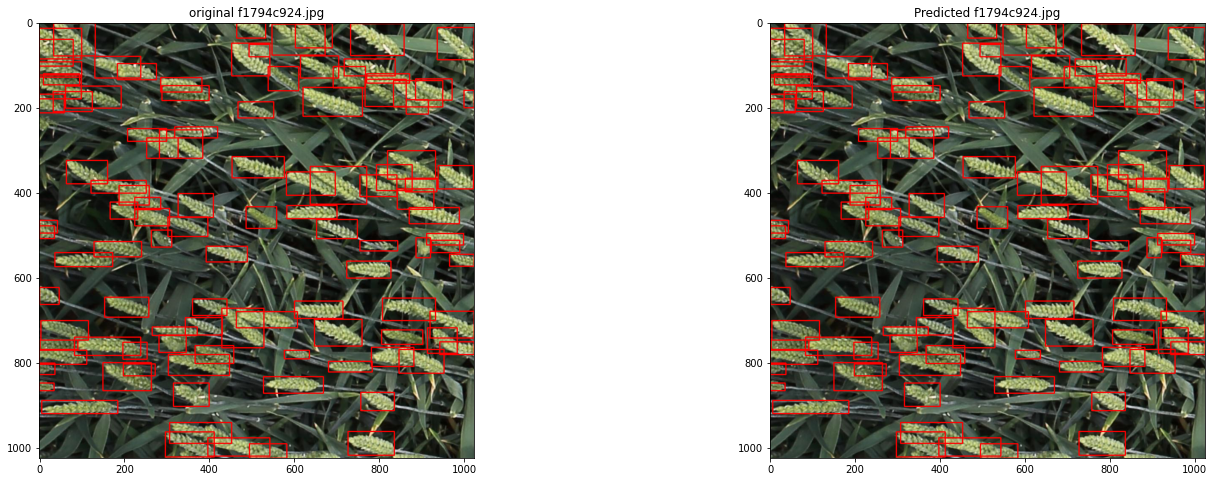

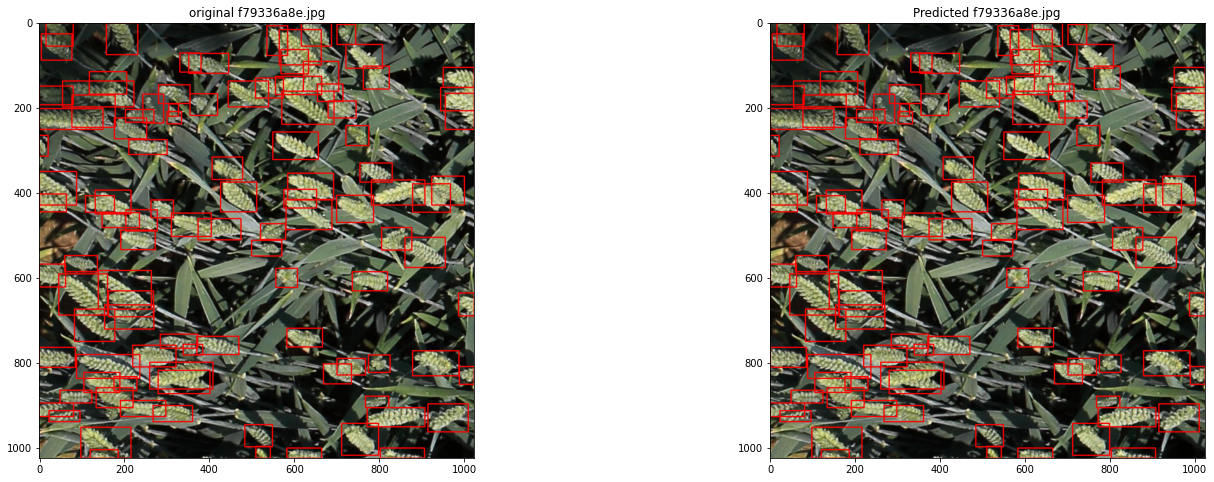

In [ ]:
df2 = df1[df1['count']>80]
for i in df2.iloc[0:3,:]['image'].values:
  img_name = i.split('/')[-1]
  if img_name in train_image:
    index = train_image.index(img_name)
    Final_pipeline(train_image,index,visualize= True)
  else:
    index = test_image.index(img_name)
    Final_pipeline(test_image,index,visualize= True)

## Visualising sparse images

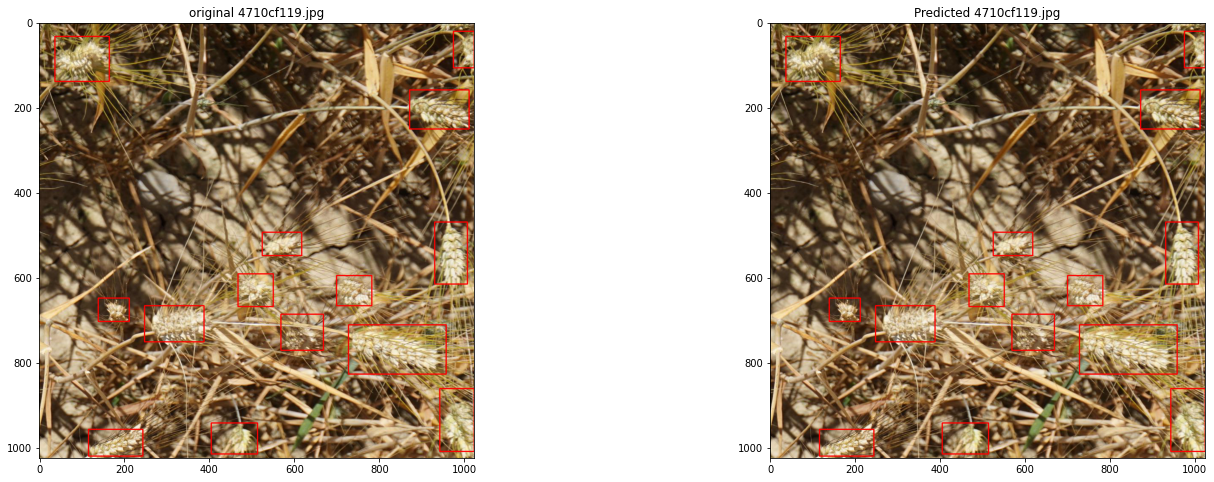

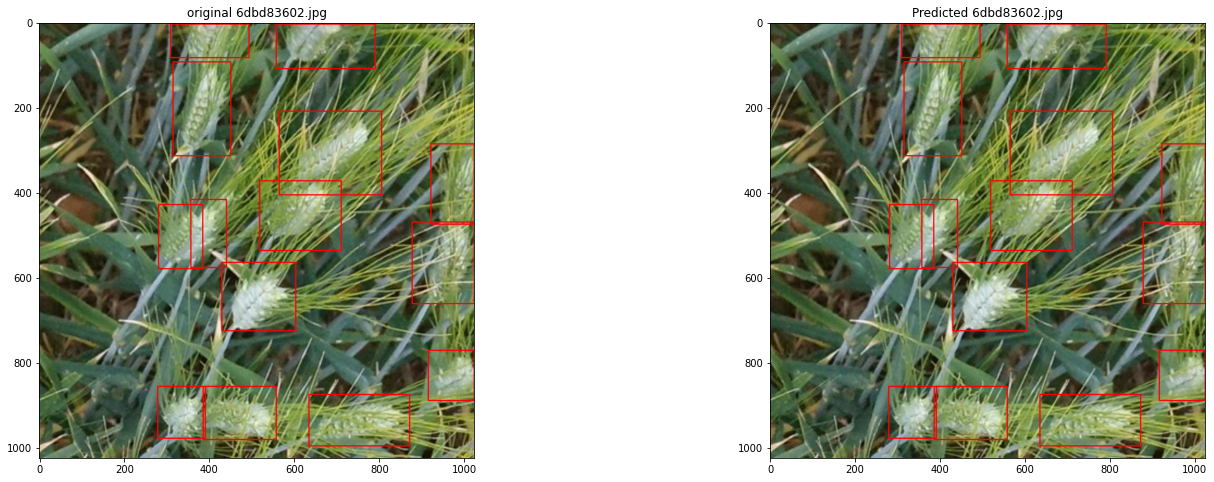

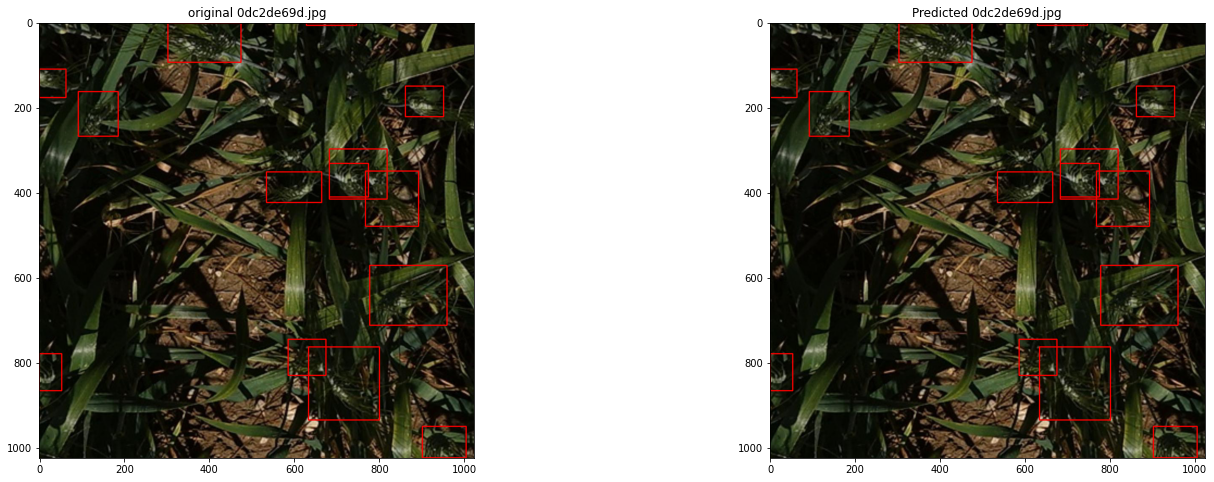

In [ ]:
df2 = df1[df1['count']<15]
for i in df2.iloc[0:3,:]['image'].values:
  img_name = i.split('/')[-1]
  if img_name in train_image:
    index = train_image.index(img_name)
    Final_pipeline(train_image,index,visualize= True)
  else:
    index = test_image.index(img_name)
    Final_pipeline(test_image,index,visualize= True)

## Visualizing very sparse images

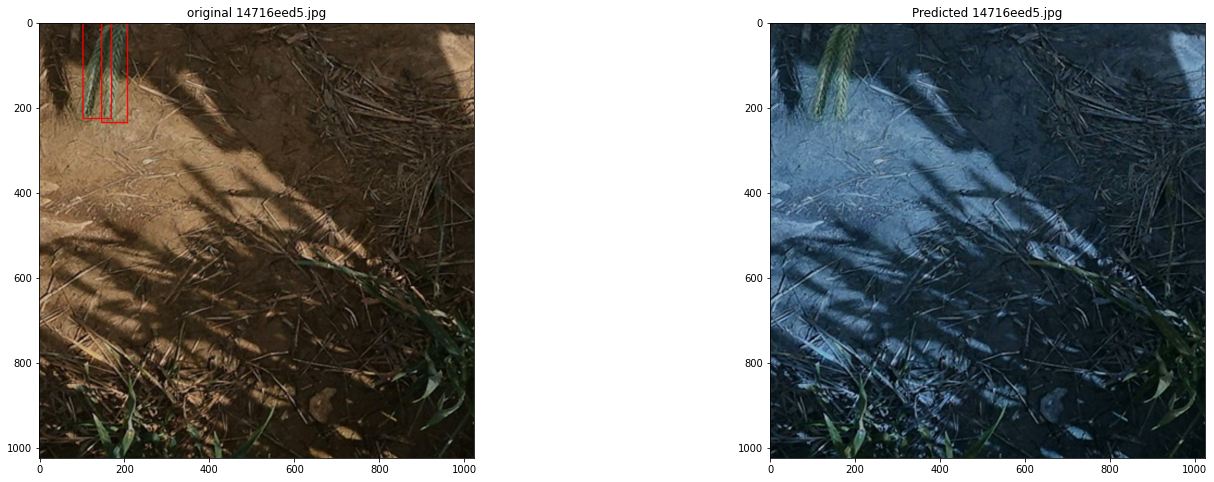

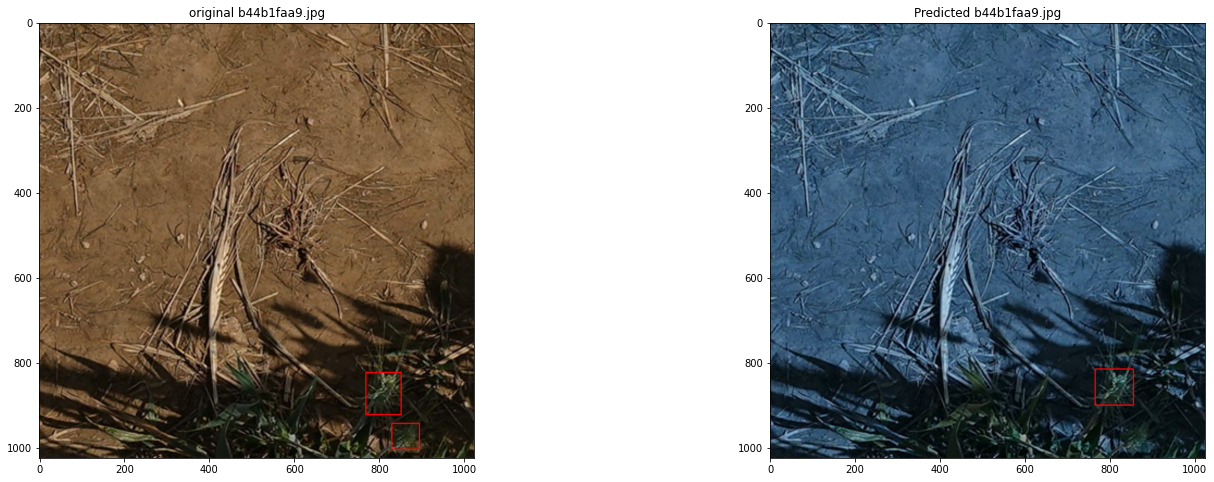

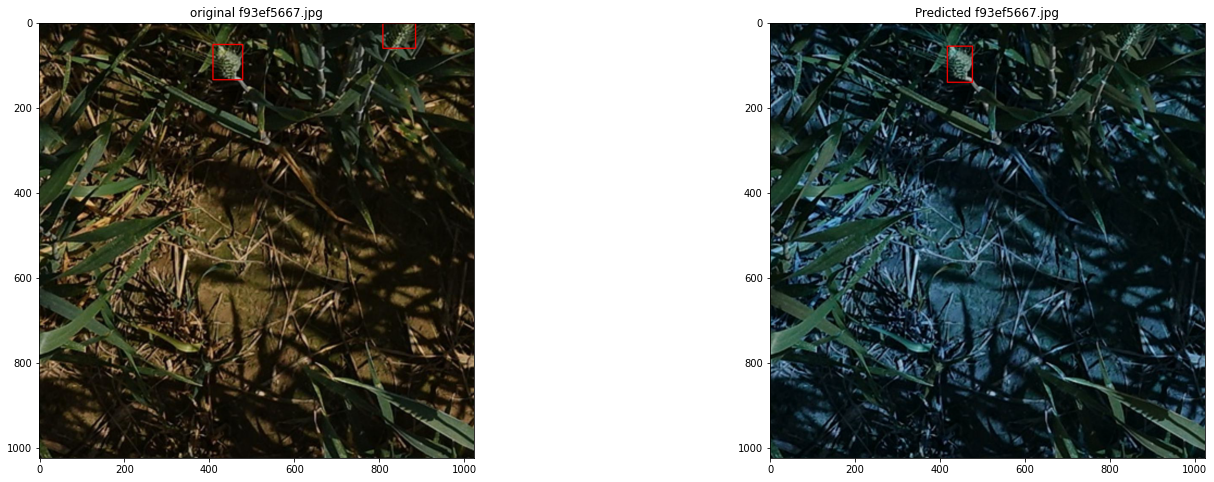

In [ ]:
df2 = df1[df1['count']<3]
for i in df2.iloc[0:3,:]['image'].values:
  img_name = i.split('/')[-1]
  if img_name in train_image:
    index = train_image.index(img_name)
    Final_pipeline(train_image,index,visualize= True)
  else:
    index = test_image.index(img_name)
    Final_pipeline(test_image,index,visualize= True)

# Step by Step Procedure

1. Download the gloabl_wheat_detection zip from kaggle and unzip the data.
2. Download the pretrained yolov3 weights.
3. Preprocess the given dataframe by expanding the bbox dimensions and calculate x_min,y_min,x_max,y_max and save it.
4. Split the data into train and validation data.
5. Import all the necessary modules that are needed.
6. Initialize the necessary variables like yolo_anchors, yolo_masks, yolo_max_boxes, batch_size, image_Size, num_Classes, class_dict that are useful for training.
7. Define yolov3 architecture that is implemented compleyetly in kears and tensorflow.
8. Define your own custom loss along with the yolo loss for object detection. I used focal loss for my task.
9. Define parse_Dataset function which will help us the map the data that is needed for trainng by converting it into the format that yolov3 expects.
10. Load both train and validation datasets.
11. Initialize the model and load pretrained weights and freeze the layers that are not required for fine tuning.
12. Start the trainnig. I used gradient tape method to train the model as it gives control over nitty gritty details in the model.
13. While trainng make sure that we are saving logs and model weights for future use.
14. Once the model is trained save the model weights instead of checkpoints.
15. For making predictions, define yolo architecute again and load the saved weights and make the predictions and visualizations.


# Observations

1. When using categorical **cross entropy loss** for negative samples i.e Bounding box for which there is no object is to high and loss for positive samples is too low for which our optimizers tries to lower negative samples loss as it's higher.Therefore, our model wasn't working well at detections.
2. So to overcome the above hurdle we have tried **focal loss** which try to down weight **negative sample loss** and hence improve our model performace.
3. For this model I have taken alpha parameter of **focal loss 0.85**, I have also tried 0.60,0.65,0.70,0.75,0.80,0.85 but at last 0.75 suited best for this model.



# Future Scope or Work

1. In our model we have used YOLOv3 which is a really good object detection technique but at the time of making this case study we already have YOLOV5 which is state of the art model.
2. So using YOLOV5 might get some better results as yolov5 is faster than yolov3 and its accuracy is reasonable and comparable too.
3. We have only 3k images for training, and we all know that more the data more the model performance for deep learning models. So training to incorporate Augmentations might be helpful.
4. There is a module called Albumenations that will help immensely while augmenting images with bounding boxes.
5. Instead of yolo we can use other models like Faster RCNN which is build for object detection tasks.
6. We can get some more images from internet and pseudo labelling them carefully and addding those images for training might help too.


# What I Gained?

1. By doing this case study I got to know every single thing that YOLOV3 does internally for object detections.
2. By implementing YOLOV3 completely in keras or tensoflow helped me gain confidence in me so that anyone with good knowledge can build an research on their own using all the tools available. 
3. If loss fucntion is continous and differentiable we can always back porpagate the loss and minimize loss using the techniques we learned in deep learning.
4. Finally I think i will be albe to implement my own versions of other models in keras or tensorflow.